<a href="https://colab.research.google.com/github/bmnds/uea-data-science-03-statistics/blob/main/%5BEstat%C3%ADstica04%5D_Trabalho_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Final da Disciplina de Estatística do Curso de Pós-Graduação em Ciência de Dados da UEA-AM
**Grupo:** Alberto, Bruno, Lelson e Levi

## O Trabalho
* Definir um tema e os objetivos a serem analisados 
* Escolher um dataframe com no mínimo cinco campos e 25 linhas, dos quais pelo menos dois devem ser numéricos
* Realizar um levantamento amostral atendendo a todos os critérios de avaliação

## A Avaliação
1. [ ] Construir tabelas e gráficos apropriados para cada variável do data frame
2. [ ] Calcular a média, mediana, moda, desvio-padrão, coeficiente de variação
e simetria das variáveis quantitativas
3. [ ] Analisar a normalidade dos dados numéricos e se existe a presença de
outliers
4. [ ] Comparar as variáveis quantitativas e descrever qual é mais homogênea
5. [ ] Calcular os respectivos Intervalos de Confiança ao nível de 95% para cada
campo do data frame
6. [ ] Comparar a média de um campo numérico em relação a um campo
categórico e responder se existe diferença estatística ao nível de 5% de significância
7. [ ] Realizar um cruzamento de dois campos categóricos e responder se existe
diferença estatística ao nível de 5% de significância.


In [1]:
# Pacotes necessários
from six.moves import urllib
from scipy import stats
from scipy.stats import binom, nbinom, poisson, uniform, expon, norm 
import pandas as pd
import statsmodels.stats.proportion as smp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import statistics as st

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Mudança da semente aleatória randômica para manter os resultados em várias execuções
np.random.seed(20201109)

# Dataset das Eleições Presidenciais dos Estados Unidos 2020
Fontes dos dados:
* https://www.kaggle.com/daithibhard/us-electoral-college-votes-per-state-17882020
* https://www.kaggle.com/unanimad/us-election-2020

Explicação sobre o funcionamento do processo eleitoral dos EUA:
* https://www.usa.gov/election

Sugestões de análises:
* https://www.nbcnews.com/politics/2020-elections/president-results
* https://www.kaggle.com/amitkumarmanjhi/us-election-2020-result-analysis

In [3]:
# Download do dataset
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1I4Hvc3wEsYuRNkinkAyY7LqcpVOLF9-O','us_elections.tar.gz')
!tar -zxvf us_elections.tar.gz
!rm us_elections.tar.gz

us_elections/
us_elections/Electoral_College.csv
us_elections/fontes.txt
us_elections/governors_county.csv
us_elections/governors_county_candidate.csv
us_elections/governors_state.csv
us_elections/house_county.csv
us_elections/house_county_candidate.csv
us_elections/house_state.csv
us_elections/president_county.csv
us_elections/president_county_candidate.csv
us_elections/president_state.csv
us_elections/senate_county.csv
us_elections/senate_county_candidate.csv
us_elections/senate_state.csv


# Bruno

## Introdução

Conforme explicado na [página oficial das eleições nos Estados Unidos](https://www.usa.gov/election), a metodologia para definição do novo presidente consiste, em:
* Para cada estado, verificar o candidato que obteve a maioria simples dos votos dos eleitores;
* Depois, somar a quantidade de delegados daquele estado ao total de votos do candidato.
* A exceção são os estados de Maine e Nebraska, onde, além dos dois delegados que votam conforme a maioria simples, também há um delegado adicional para cada distrito eleitoral, sendo dois distritos em Maine e três em Nebraska, que devem ser contabilizados separadamente.

## Visão geral dos dados

Os dados escolhidos para a análise da votação presidencial dos Estados Unidos de 2020 estão disponíveis, em: [link para o dataset](https://www.kaggle.com/unanimad/us-election-2020).

Eles foram baixados em 09/11 e representam o resultado parcial da eleição até 08/11.

O conjunto de dados da eleição consiste em 3 arquivos, são eles:
* **president_state.csv**, representando uma visão estadual da votação para presidente, com a base de delegados e o total de votos do estado;
* **president_county.csv**, representando a visão a nível de condado da votação para presidente; 
* **president_county_candidate.csv**, representando o quantitativo de votos de cada candidato que estava concorrendo à presidência dentro de cada condado, bem como o seu partido eleitoral.

O dataset **president_state.csv** consiste das colunas **votes**, totalizando a quantidade de votos daquele estado e  **electoral_vote**, indicando a quantidade de delegados daquele colégio eleitoral.

In [173]:
db_president_state = pd.read_csv('us_elections/president_state.csv')
db_president_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state           52 non-null     object 
 1   votes           52 non-null     int64  
 2   electoral_vote  51 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ KB


Porém, foi constatado que apenas 1 estado possui a quantidade de delegados preenchida e, portanto, será necessário buscar outro dataset que tenha a informação completa.

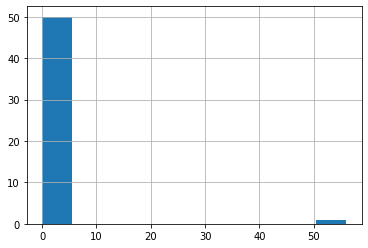

In [174]:
db_president_state.electoral_vote.hist()

Para identificar a quantidade de delegados por estado, encontramos o dataset com a base de colégios eleitorais, em: [link do segundo dataset](https://www.kaggle.com/daithibhard/us-electoral-college-votes-per-state-17882020).
O arquivo **Electoral_College.csv** possui a quantidade de delegados por estado desde 1788, indicando o estado e a quantidade de delegados.

In [175]:
# Nos EUA, cada Estado possui um 'Peso' na votação representado pela quantidade de 'Ellectors' do colégio eleitoral
db_electoral = pd.read_csv('us_elections/Electoral_College.csv')
db_electoral.columns = ['year', 'state', 'electoral_votes']
db_electoral.head()
# Define a representatividade de cada Estado em percentual
#db_electoral['Pct'] = (100* db_electoral.Votes / db_electoral.groupby('Year').Votes.transform(sum))

,year,state,electoral_votes
0,1788,Alabama,NaN
1,1792,Alabama,NaN
2,1796,Alabama,NaN
3,1800,Alabama,NaN
4,1804,Alabama,NaN


Para nossa análise, é suficiente manter apenas os dados do ano de 2020.

In [176]:
# Padroniza o nome do Distrito de Columbia
db_electoral.loc[471,'state'] = 'District of Columbia'
# O nosso interesse é nos valores de 2020
db_electoral_2020 = db_electoral[db_electoral.year.eq(2020)].sort_values('state').reset_index(drop=True)
db_electoral_2020.head()

,year,state,electoral_votes
0,2020,Alabama,9.0
1,2020,Alaska,3.0
2,2020,Arizona,11.0
3,2020,Arkansas,6.0
4,2020,California,55.0


In [177]:
#TODO plotar o mapa dos EUA indicando o "peso" de cada estado com cores

O dataset **president_county.csv** descreve a quantidade de votos por estado, **state**, e condado, **county**. Representa a quantidade total de votos por condado na coluna **total_votes** e a quantidade atual de votos já computados na coluna **current_votes**, bem como a porcentagem de votos apurados em relação ao total na coluna **percent**.

In [178]:
db_president_county = pd.read_csv('us_elections/president_county.csv')
db_president_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4633 entries, 0 to 4632
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state          4633 non-null   object
 1   county         4633 non-null   object
 2   current_votes  4633 non-null   int64 
 3   total_votes    4633 non-null   int64 
 4   percent        4633 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 181.1+ KB


Esse dataset possui três colunas numéricas, **total_votes**, **current_votes**  e **percent**. Porém, também apresentou inconsistências, pois, a quantidade de votos computados foi maior do que a quantidade total de votos em alguns condados:

In [179]:
db_inconsistent_president_county = db_president_county[db_president_county.apply(lambda row: row['current_votes'] > row['total_votes'], axis=1)].sort_values('percent', ascending=False)
inconsistency = db_inconsistent_president_county.county.count() / db_president_county.county.count()
print('Em ' + str(round(100*inconsistency,2)) + '% dos condados a quantidade atual de votos é maior que o total')

Em 35.23% dos condados a quantidade atual de votos é maior que o total


In [180]:
#TODO projetar até quanto esse valor pode crescer até o final da eleição

Para simplificar a análise, quando o valor de **current_votes** for maior uqe  **total_votes**, iremos modificar o total para ser igual ao valor corrente, caso contrário, não será possível estimar o vencedor da eleição.

In [181]:
db_president_state = db_president_county.groupby('state').sum().reset_index()
db_president_state.total_votes = db_president_state.apply(lambda row: row['total_votes'] if row['total_votes'] > row['current_votes'] else row['current_votes'], axis=1)
db_president_state.percent = db_president_state.apply(lambda row: 100 * row['current_votes'] / row['total_votes'], axis=1)
db_president_state.head()

,state,current_votes,total_votes,percent
0,Alabama,2309900,2309900,100.000000
1,Alaska,131885,366006,36.033562
2,Arizona,3322535,3403744,97.614127
3,Arkansas,1216818,1250053,97.341313
4,California,14414296,15813337,91.152778


Precisamos adicionar a coluna **remaining_votes** ao dataset para podermos verificar se ainda há chance do segundo colocado alcançar a maioria dos votos nos estados em que o primeiro colocado ainda não atingiu 50% ou mais de votos.

In [182]:
db_president_state['remaining_votes'] = db_president_state.total_votes - db_president_state.current_votes
db_president_state.sort_values('percent').head(5)

,state,current_votes,total_votes,percent,remaining_votes
1,Alaska,131885,366006,36.033562,234121
32,New York,6641544,8904800,74.583865,2263256
8,District of Columbia,279152,348619,80.073662,69467
30,New Jersey,3610021,4349127,83.005647,739106
20,Maryland,2497959,3002298,83.201568,504339


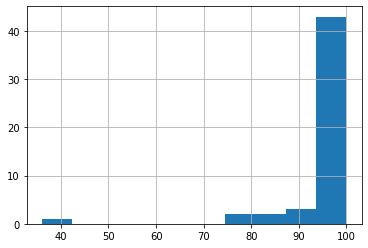

In [183]:
db_president_state.percent.hist()

In [184]:
db_state_electoral_votes = pd.merge(db_president_state, db_electoral_2020, how='left', on='state', )
del db_state_electoral_votes['year']
db_state_electoral_votes.head()

,state,current_votes,total_votes,percent,remaining_votes,electoral_votes
0,Alabama,2309900,2309900,100.000000,0,9.0
1,Alaska,131885,366006,36.033562,234121,3.0
2,Arizona,3322535,3403744,97.614127,81209,11.0
3,Arkansas,1216818,1250053,97.341313,33235,6.0
4,California,14414296,15813337,91.152778,1399041,55.0


O dataset **president_county_candidate.csv** possui 4 colunas categóricas e 1 coluna numérica. São elas: o estado, **state**; o condado, **county**; o candidato, **candidate**; o partido ao qual ele está filiado, **party**; e a quantidade de votos que o candidato já recebeu naquele condado, **votes**.

In [185]:
db_president_county_candidate = pd.read_csv('us_elections/president_county_candidate.csv')
db_president_county_candidate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31167 entries, 0 to 31166
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      31167 non-null  object
 1   county     31167 non-null  object
 2   candidate  31167 non-null  object
 3   party      31167 non-null  object
 4   votes      31167 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.2+ MB


A distribuição de partidos por condado onde obtiveram pelo menos 1 voto para seu candidato se assemelha a uma distribuição exponencial.

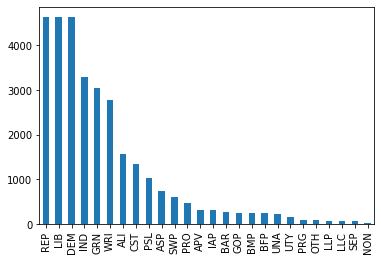

In [186]:
db_president_county_candidate.party.value_counts().plot(kind='bar')

### Calculando o total de votos computados por Candidato em cada Estado

In [187]:
# totalizando os votos por estado e candidato, já em ordem descrescente pela quantidade de votos
db_president_state_candidate = db_president_county_candidate.groupby(['state', 'candidate', 'party']).sum('votes').sort_values(by = ['state', 'votes'], ascending = [True, False]).reset_index()
db_president_state_candidate.head(4)

,state,candidate,party,votes
0,Alabama,Donald Trump,REP,1434159
1,Alabama,Joe Biden,DEM,843473
2,Alabama,Jo Jorgensen,LIB,24994
3,Alabama,Write-ins,WRI,7274


In [188]:
# define primeiro mais votado em cada Estado
db_1st_place_by_state = db_president_state_candidate.groupby('state').nth(0).reset_index()
db_1st_place_by_state.columns = ['state', '1st_candidate', '1st_party', '1st_votes']
db_1st_place_by_state.head()

,state,1st_candidate,1st_party,1st_votes
0,Alabama,Donald Trump,REP,1434159
1,Alaska,Donald Trump,REP,80999
2,Arizona,Joe Biden,DEM,1643664
3,Arkansas,Donald Trump,REP,761251
4,California,Joe Biden,DEM,9315259


In [189]:
# combina com o dataset de resultados
db_1st_results = pd.merge(db_state_electoral_votes, db_1st_place_by_state , how='left', on='state', )
db_1st_results['1st_percent'] = 100* db_1st_results['1st_votes'] / db_1st_results.current_votes
db_1st_results.head()

,state,current_votes,total_votes,percent,remaining_votes,electoral_votes,1st_candidate,1st_party,1st_votes,1st_percent
0,Alabama,2309900,2309900,100.000000,0,9.0,Donald Trump,REP,1434159,62.087493
1,Alaska,131885,366006,36.033562,234121,3.0,Donald Trump,REP,80999,61.416385
2,Arizona,3322535,3403744,97.614127,81209,11.0,Joe Biden,DEM,1643664,49.470179
3,Arkansas,1216818,1250053,97.341313,33235,6.0,Donald Trump,REP,761251,62.560794
4,California,14414296,15813337,91.152778,1399041,55.0,Joe Biden,DEM,9315259,64.625140


In [190]:
# define o segundo mais votado em cada Estado
db_2nd_place_by_state = db_president_state_candidate.groupby('state').nth(1).reset_index()
db_2nd_place_by_state.columns = ['state', '2nd_candidate', '2nd_party', '2nd_votes']
db_2nd_place_by_state.head()

,state,2nd_candidate,2nd_party,2nd_votes
0,Alabama,Joe Biden,DEM,843473
1,Alaska,Joe Biden,DEM,45758
2,Arizona,Donald Trump,REP,1626679
3,Arkansas,Joe Biden,DEM,420985
4,California,Donald Trump,REP,4812735


In [200]:
# combina com o dataset de resultados
db_results_by_state = pd.merge(db_1st_results, db_2nd_place_by_state , how='left', on='state', )
db_results_by_state['2nd_percent'] = 100* db_results_by_state['2nd_votes'] / db_results_by_state.current_votes
db_results_by_state.head()

,state,current_votes,total_votes,percent,remaining_votes,electoral_votes,1st_candidate,1st_party,1st_votes,1st_percent,2nd_candidate,2nd_party,2nd_votes,2nd_percent
0,Alabama,2309900,2309900,100.000000,0,9.0,Donald Trump,REP,1434159,62.087493,Joe Biden,DEM,843473,36.515563
1,Alaska,131885,366006,36.033562,234121,3.0,Donald Trump,REP,80999,61.416385,Joe Biden,DEM,45758,34.695379
2,Arizona,3322535,3403744,97.614127,81209,11.0,Joe Biden,DEM,1643664,49.470179,Donald Trump,REP,1626679,48.958973
3,Arkansas,1216818,1250053,97.341313,33235,6.0,Donald Trump,REP,761251,62.560794,Joe Biden,DEM,420985,34.597204
4,California,14414296,15813337,91.152778,1399041,55.0,Joe Biden,DEM,9315259,64.625140,Donald Trump,REP,4812735,33.388623


### Consolidando todos os dados de interesse em um único dataframe de resultados

In [208]:
# calcula se o 2o colocado ainda tem chances de passar o 1o colocado
db_results_by_state['1st_won'] = db_results_by_state.apply(lambda row: False if (row['2nd_votes'] + row['remaining_votes'] >= row['1st_votes']) else True, axis=1)
db_results_by_state[db_results_by_state['1st_won'].eq(False)]

,state,current_votes,total_votes,percent,remaining_votes,electoral_votes,1st_candidate,1st_party,1st_votes,1st_percent,2nd_candidate,2nd_party,2nd_votes,2nd_percent,1st_won
1,Alaska,131885,366006,36.033562,234121,3.0,Donald Trump,REP,80999,61.416385,Joe Biden,DEM,45758,34.695379,False
2,Arizona,3322535,3403744,97.614127,81209,11.0,Joe Biden,DEM,1643664,49.470179,Donald Trump,REP,1626679,48.958973,False
28,Nevada,1323719,1400801,94.497291,77082,6.0,Joe Biden,DEM,664162,50.173942,Donald Trump,REP,629879,47.584042,False
30,New Jersey,3610021,4349127,83.005647,739106,14.0,Joe Biden,DEM,2108110,58.396059,Donald Trump,REP,1449928,40.163977,False
32,New York,6641544,8904800,74.583865,2263256,29.0,Joe Biden,DEM,3699332,55.699879,Donald Trump,REP,2850352,42.917008,False
33,North Carolina,5464097,5652431,96.668088,188334,15.0,Donald Trump,REP,2733687,50.029987,Joe Biden,DEM,2658280,48.649942,False
38,Pennsylvania,6765139,6827967,99.079843,62828,20.0,Joe Biden,DEM,3361668,49.691041,Donald Trump,REP,3315998,49.015963,False


### Calculando o resultado parcial da eleição

In [215]:
# o primeiro a atingir atingir 270 votos de delegados é declarado presidente
db_results = db_results_by_state[db_results_by_state['1st_won']].groupby(['1st_candidate', '1st_party']).sum('electoral_votes').reset_index().sort_values('electoral_votes', ascending=False)[['1st_candidate', '1st_party', 'electoral_votes']]
db_results.columns = ['candidate', 'party', 'electoral_votes']
db_results

,candidate,party,electoral_votes
1,Joe Biden,DEM,226.0
0,Donald Trump,REP,214.0


In [ ]:
#TODO calcular a chance de Biden ser o novo presidente

In [ ]:
#TODO calcular a chance de Trump ser o novo presidente